# Задача 1

**Загрузите датасет для регрессии, выполните предварительную обработку (удалите пропуски, приведите все признаки к числам), выделите целевой признак и предикторы, разбейте данные на обучающую и тестовую выборку.**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt, pow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime as dt
import folium

- **Загрузка датасета**

In [2]:
df = pd.read_csv('../data/trip_duration_task.csv')

df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,id1080784,2.0,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,400
1,id0889885,1.0,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,1100
2,id0857912,2.0,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,1635
3,id3744273,2.0,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,1141
4,id0232939,1.0,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,848
...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2.0,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,296
729318,id0102861,1.0,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,315
729319,id0439699,1.0,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,673
729320,id2078912,1.0,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,447


## Предобработка датасета

- **Удаление столбцов id, dropoff_datetime(т.к. является искомым)**

In [3]:
df1 = df.drop(["id", "dropoff_datetime"], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vendor_id          727135 non-null  float64
 1   pickup_datetime    729322 non-null  object 
 2   passenger_count    729322 non-null  int64  
 3   pickup_longitude   729322 non-null  float64
 4   pickup_latitude    727475 non-null  float64
 5   dropoff_longitude  729322 non-null  float64
 6   dropoff_latitude   729322 non-null  float64
 7   trip_duration      729322 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 44.5+ MB


- **Исключение пустых строк**

In [4]:
df2 = df1.dropna()

- **Отбор основных путей перездок для улучшения результата прогноза**

In [5]:
dfl = df.head(500)
m = folium.Map(location=[40.753093719482415, -73.97315979003906], zoom_start=12)
result = [folium.Marker([x1, y1]).add_to(m) and folium.Marker([x2, y2]).add_to(m) for x1, y1, x2, y2 in zip(dfl['pickup_latitude'], dfl['pickup_longitude'], dfl['dropoff_latitude'], dfl['dropoff_longitude'])]
m.save("name1.html")
#40.691510, -74.020491
#40.820779, -73.919535

df3 = df2[(40.691510 < df2.pickup_latitude) & (40.691510 < df2.dropoff_latitude) & (df2.pickup_latitude < 40.820779) & (df2.dropoff_latitude < 40.820779)]
df3 = df3[(-74.020491 < df3.pickup_longitude) & (-74.020491 < df3.dropoff_longitude) & (df3.pickup_longitude < -73.919535) & (df3.dropoff_longitude < -73.919535)]

![plot](./loc.png)

- **Выделение прзнака из даты отправки - часовой период, из кол-ва пассажиров - 2 типа вместительности; удаление столбца vendor_idt**

In [6]:
df4 = df3
df_hours = pd.get_dummies(df4["pickup_datetime"].apply(lambda date: int(date[11:13])), prefix="hour")
df4["hour_4_9"] = df_hours.hour_4 + df_hours.hour_5 + df_hours.hour_6 + df_hours.hour_7 + df_hours.hour_8 + df_hours.hour_9
df4["hour_10_15"] = df_hours.hour_10 + df_hours.hour_11 + df_hours.hour_12 + df_hours.hour_13 + df_hours.hour_14 + df_hours.hour_15
df4["hour_16_15"] = df_hours.hour_16 + df_hours.hour_17 + df_hours.hour_18 + df_hours.hour_19 + df_hours.hour_20 + df_hours.hour_21
df4["hour_night"] = df_hours.hour_22 + df_hours.hour_23 + df_hours.hour_0 + df_hours.hour_1 + df_hours.hour_2 + df_hours.hour_3

print(df4["passenger_count"].unique())
df4["pas0-3"] = df4["passenger_count"].apply(lambda count: 1 if count < 4 else 0)
df4["pas4-6"] = df4["passenger_count"].apply(lambda count: 1 if count > 3 else 0)

df4 = df4.drop(["pickup_datetime", "vendor_id", "passenger_count"], axis=1)
df4.info()

[1 2 6 3 4 5 0]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629577 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_longitude   629577 non-null  float64
 1   pickup_latitude    629577 non-null  float64
 2   dropoff_longitude  629577 non-null  float64
 3   dropoff_latitude   629577 non-null  float64
 4   trip_duration      629577 non-null  int64  
 5   hour_4_9           629577 non-null  uint8  
 6   hour_10_15         629577 non-null  uint8  
 7   hour_16_15         629577 non-null  uint8  
 8   hour_night         629577 non-null  uint8  
 9   pas0-3             629577 non-null  int64  
 10  pas4-6             629577 non-null  int64  
dtypes: float64(4), int64(3), uint8(4)
memory usage: 40.8 MB


- **Избавляемся от слишком завышенных параметров времени поездки**

In [7]:
df5 = df4
print(df5[df5["trip_duration"]>8000].shape[0])
df5 = df5[df5["trip_duration"]<8000]
df5.info()

838
<class 'pandas.core.frame.DataFrame'>
Int64Index: 628739 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_longitude   628739 non-null  float64
 1   pickup_latitude    628739 non-null  float64
 2   dropoff_longitude  628739 non-null  float64
 3   dropoff_latitude   628739 non-null  float64
 4   trip_duration      628739 non-null  int64  
 5   hour_4_9           628739 non-null  uint8  
 6   hour_10_15         628739 non-null  uint8  
 7   hour_16_15         628739 non-null  uint8  
 8   hour_night         628739 non-null  uint8  
 9   pas0-3             628739 non-null  int64  
 10  pas4-6             628739 non-null  int64  
dtypes: float64(4), int64(3), uint8(4)
memory usage: 40.8 MB


In [9]:
df5.to_csv("../data/taxi.csv", index_label = False)

- **Выделение целевого признака и предикатов.**

In [8]:
y = df5['trip_duration']
X = df5.drop(['trip_duration'], axis = 1)

In [456]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((188621, 10), (188621,), (440118, 10), (440118,))

# Задача 2

**Решите задачу регрессии на ваших данных с использованием моделей sklearn (линейная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.**

- **!Подготовка нескольких гиперпараметров**

In [11]:
parameters = {'alpha': np.arange(0.1, 1, 0.05)}

- **Линейная регрессия.**

In [113]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)


In [114]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
score_lr = r2_score(y_pred, y_test)
print(f'R^2: {score_lr}')

MAE: 341.11165187517895
MSE: 203634.64584582997
RMSE: 451.25895652699234
MAPE: 1.0196725110633162
R^2: -31.324020524673877


In [115]:
lr.coef_

array([-1.99293250e+03, -2.17956037e+02,  2.75678045e+03, -2.77367576e+03,
       -9.88144914e+14, -9.88144914e+14, -9.88144914e+14, -9.88144914e+14,
       -1.15919226e+15, -1.15919226e+15])

- **Линейная регрессия. Регуляризация L1 / Ridge.**

In [116]:
# L1(RandomizedSearchCV)
ridge_optimal = RandomizedSearchCV(Ridge(), parameters).fit(X_train, y_train)
ridge = Ridge(alpha=ridge_optimal.best_params_['alpha']).fit(X_train, y_train)
y_pred = ridge.predict(X_test)


In [117]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
score_lr_L1_RandomSearchCV = r2_score(y_pred, y_test)
print(f'R^2: {score_lr_L1_RandomSearchCV}')

MAE: 341.07249114756905
MSE: 203629.64862191404
RMSE: 451.2534195127102
MAPE: 1.0195370815279488
R^2: -31.768557646892674


In [118]:
ridge.coef_

array([-1964.34156997,  -222.93839293,  2725.31972878, -2757.36071385,
         -31.28912331,    80.55209789,    15.49758785,   -64.76056251,
          -4.85354084,     4.85354083])

In [119]:
# L1(GridSearchCV)
ridge_optimal = GridSearchCV(Ridge(), parameters).fit(X_train, y_train)
ridge = Ridge(alpha=ridge_optimal.best_params_['alpha']).fit(X_train, y_train)
y_pred = ridge.predict(X_test)

In [120]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
score_lr_L1_GridSearchCV = r2_score(y_pred, y_test)
print(f'R^2: {score_lr_L1_GridSearchCV}')

MAE: 341.07249114756905
MSE: 203629.64862191404
RMSE: 451.2534195127102
MAPE: 1.0195370815279488
R^2: -31.768557646892674


In [121]:
ridge.coef_

array([-1964.34156997,  -222.93839293,  2725.31972878, -2757.36071385,
         -31.28912331,    80.55209789,    15.49758785,   -64.76056251,
          -4.85354084,     4.85354083])

- **Линейная регрессия. Регуляризация L2 / Lasso.**

In [122]:
# L2(RandomizedSearchCV)
lasso_optimal = RandomizedSearchCV(Lasso(), parameters).fit(X_train, y_train)
lasso = Lasso(alpha=lasso_optimal.best_params_['alpha']).fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [123]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
score_lr_L2_RandomSearchCV = r2_score(y_pred, y_test)
print(f'R^2: {score_lr_L2_RandomSearchCV}')

MAE: 341.2959699712704
MSE: 203859.9602937503
RMSE: 451.5085384505484
MAPE: 1.020180086831387
R^2: -40.87055544168539


In [124]:
lasso.coef_

array([-1.25114887e+03, -4.17112169e+02,  1.75349077e+03, -2.19594381e+03,
       -2.50487021e+01,  8.56661051e+01,  2.22177022e+01, -5.28396309e+01,
       -8.50368737e+00,  5.75595419e-15])

In [125]:
# L2(GridSearchCV)
lasso_optimal = GridSearchCV(Lasso(), parameters).fit(X_train, y_train)
lasso = Lasso(alpha=lasso_optimal.best_params_['alpha']).fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [126]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
score_lr_L2_GridSearchCV = r2_score(y_pred, y_test)
print(f'R^2: {score_lr_L2_GridSearchCV}')

MAE: 341.2959699712704
MSE: 203859.9602937503
RMSE: 451.5085384505484
MAPE: 1.020180086831387
R^2: -40.87055544168539


In [127]:
lasso.coef_

array([-1.25114887e+03, -4.17112169e+02,  1.75349077e+03, -2.19594381e+03,
       -2.50487021e+01,  8.56661051e+01,  2.22177022e+01, -5.28396309e+01,
       -8.50368737e+00,  5.75595419e-15])

# Задача 3

**Решите задачу регрессии на ваших данных с использованием моделей sklearn (полиномиальная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.**

- **Добавление предиката, степень полинома 2.**

In [463]:
pf = PolynomialFeatures(4)
X_train_p = pf.fit_transform(X_train)
X_test_p = pf.fit_transform(X_test)


- **Полиномиальная регрессия.**

In [464]:
pr = LinearRegression().fit(X_train_p, y_train)
y_pred = pr.predict(X_test_p)


In [465]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
score_pr = r2_score(y_pred, y_test)
print(f'R^2: {score_pr}')

MAE: 217.96852361029633
MSE: 98226.84682480925
RMSE: 313.4116252228198
MAPE: 0.7555453215292696
R^2: 0.125516104388256


In [30]:
pr.coef_

array([ 9.62274759e+02, -8.54688002e+08, -1.03356501e+09, ...,
        0.00000000e+00,  0.00000000e+00, -4.38519146e+06])

- **Полиномиальная регрессия. Регуляризация L1 / Ridge.**

In [139]:
ridge = Ridge().fit(X_train_p, y_train)
y_pred = ridge.predict(X_test_p)

In [140]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
score_pr_L1 = r2_score(y_pred, y_test)
print(f'R^2: {score_pr_L1}')

MAE: 241.29299822364837
MSE: 117277.6125851629
RMSE: 342.4581910031689
MAPE: 0.8186678954252306
R^2: -0.2725200597986355


# Задача 4

**Вычислите значения метрик $R^2$, MAE, MSE, RMSE, MAPE для всех обученных моделей; выберите лучшую модель.**

- **Сравнение всех моделей по наибольшему коэффициенту детерминации.**

In [143]:
print(score_lr)
print(score_lr_L1_RandomSearchCV)
print(score_lr_L1_GridSearchCV)
print(score_lr_L2_RandomSearchCV)
print(score_lr_L2_GridSearchCV)
print("----")
print(score_pr)
print(score_pr_L1)

-31.324020524673877
-31.768557646892674
-31.768557646892674
-40.87055544168539
-40.87055544168539
----
0.12677161467913023
-0.2725200597986355


**Наилучшей моделью оказалась: Полиномиальная регрессия 4 степени**

# Задача 5
- **Самостоятельно реализуйте (желательно в виде класса) модель линейной регрессии с регуляризацией (можете выбрать L1 или L2).**
- **Самостоятельно реализуйте вычисление всех используемых метрик (в виде функций, принимающих два аргумента).**
- **Обучите вашу модель линейной регрессии на ваших данных; оцените качество с помощью реализованных вами метрик.**

In [544]:
class Metrics:
    def conf_matrix(y_test, y_pred):
        
    @staticmethod
    def  MAE(y_test, y_pred): #mean_absolute_error
        real, pred = np.array(y_test), np.array(y_pred)
        return float(np.mean(np.abs(real - pred)))
    @staticmethod
    def MSE(y_test, y_pred): #mean_squared_error
        real, pred = np.array(y_test), np.array(y_pred)
        return float(np.mean((real - pred) ** 2))
    @staticmethod
    def RMSE(y_test, y_pred): #root_mean_squared_error
        return float(np.sqrt(Metrics.mean_squared_error(y_test, y_pred)))
    @staticmethod
    def MAPE(y_test, y_pred): #mean_absolute_percentage_error
        y_true, predictions = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((real - pred) / np.abs(real)))
    @staticmethod
    def R2(y_test, y_pred): #r2_score
        real, pred = np.array(y_test), np.array(y_pred)
        return float(1 - np.sum((real - pred)**2) / np.sum((real - np.mean(real))**2))

In [554]:
class MyLinearRegression:
    def __init__(self, iterations = 1000, learning_rate = 1e-4):
        self.lr = learning_rate  
        self.i = iterations        

    def loss_func(self, x, y, w):
        return sum((np.dot(x, w) - y) ** 2)/x.shape[1] #функция потерь sum((<w, x> - y)^2) * 1/len(x)
    
    def gradient(self, X, y, XT, l, w):
        return w - self.lr * 2 * np.dot(XT, np.dot(X, w) - y) / l #функция для вычисления градиента
                                                                  #w -n∇Q(w, X) = w - 2n/l * X.T(Xw - y)

    def fit(self, x, y):
        loss_abs = np.inf #переменная, отвечающая за прекращение работы алгоритма при минимальном изменении знач. функции потерь 
        eps = 1e-4
        
        X = x#self.transform(x)
        w = np.zeros(X.shape[1]) #изначально веса = 0
        iter = 0
        XT = X.T
        l = X.shape[0]
        while iter <= self.i:
            loss = self.loss_func(X, y, w)
            w_save = w
            w = self.gradient(X, y, XT, l, w)
            loss_abs_save = loss_abs
            loss_abs = np.abs(loss - self.loss_func(X, y,w))
            if (loss_abs > loss_abs_save):
                loss_abs = loss_abs_save
                self.lr *= 0.99
            if (loss_abs <= eps):
                break
            iter += 1
            
        self.w = w
        
        
    def predict(self, x):
        return np.dot(x, self.w) #ожидаемые y

In [551]:
class MyRidge:
    def __init__(self, iterations = 1000, learning_rate = 1e-4, alpha = 2):
        self.lr = learning_rate  
        self.i = iterations        
        self.a = alpha

    def loss_func(self, x, y, w):
        return sum((np.dot(x, w) - y) ** 2 + self.a * sum(w**2))/x.shape[1] #функция потерь sum((<w, x> - y)^2) * 1/len(x)
    def gradient(self, X, y, XT, l, w):
        return w - self.lr * (2 * np.dot(XT, np.dot(X, w) - y) + self.a * sum(2 * w)) / l #функция для вычисления градиента
                                                                  #w -n∇Q(w, X) = w - 2n/l * X.T(Xw - y)

    def fit(self, x, y):
        loss_abs = np.inf #переменная, отвечающая за прекращение работы алгоритма при минимальном изменении знач. функции потерь 
        eps = 1e-4
        
        X = x#self.transform(x)
        w = np.zeros(X.shape[1]) #изначально веса = 0
        iter = 0
        XT = X.T
        l = X.shape[0]
        while iter <= self.i:
            loss = self.loss_func(X, y, w)
            w_save = w
            w = self.gradient(X, y, XT, l, w)
            loss_abs_save = loss_abs
            loss_abs = np.abs(loss - self.loss_func(X, y,w))
            if (loss_abs > loss_abs_save):
                loss_abs = loss_abs_save
                self.lr *= 0.99
            if (loss_abs <= eps):
                break
            iter += 1
            
        self.w = w
        return self
        
        
    def predict(self, x):
        return np.dot(x, self.w) #ожидаемые y

In [501]:
(X1_train, 
 X2_train, 
 y1_train, y2_train) = train_test_split(X_train_p, y_train, 
                                     test_size=0.93, 
                                     random_state=0)
len(X1_train)

13203

In [504]:
from sklearn.datasets import make_regression
Xmr, ymr = make_regression(n_samples=5000, n_features=7, noise=30, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(Xmr, ymr, test_size=0.3)
len(X3_train)
print(X3_train.shape)

(3500, 7)


In [555]:
#print(pr.coef_)
parameters = np.arange(0.1, 1, 0.05)
mlr = MyLinearRegression(iterations =10000, learning_rate = 3)
mlrr = MyRidge(iterations =10000, learning_rate = 3, alpha = 0.5)
lr1 = LinearRegression()
mlrr.fit(X3_train, y3_train)
lr1.fit(X3_train, y3_train)
mlr.fit(X3_train, y3_train)
stats = [ Metrics.MSE(MyRidge(iterations =10000, learning_rate = 3, alpha = i).fit(X3_train, y3_train).predict(X3_test), y3_test) for i in parameters]

862.9485781966463
0.25000000000000006


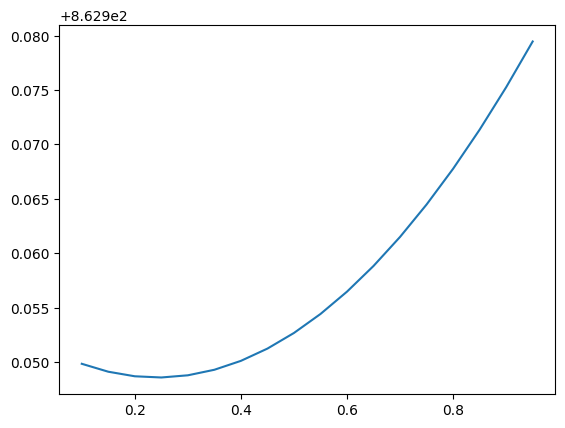

In [559]:
plt.plot(parameters, stats)
print(min(stats))
print(parameters[stats.index(min(stats))])


In [535]:
pred1 = mlr.predict(X3_test)
pred2 = lr1.predict(X3_test)
pred3 = mlrr.predict(X3_test)
print(Metrics.r_2_score(pred1, y3_test))
print(Metrics.r_2_score(pred2, y3_test))
print(Metrics.r_2_score(pred3, y3_test))
#-1523081.8375414188
#-1496222.53845041
#-0.008642139528650672

0.9569841451575292
0.9569833204182712
0.9569186819778042
